In [64]:
import pandas as pd
import itertools
import json
from statistics import mean
from tqdm import tqdm
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
tqdm.pandas()

In [65]:
def dataframe_from_json(filepath):
    with open(filepath) as f:
        data = json.load(f)
    data = list(itertools.chain(*data))
    return pd.DataFrame.from_dict(data)


In [66]:
def get_repayment_history(payment_hist_string):
    if isinstance(payment_hist_string, str):
        return [int(payment_hist_string[i:i+3]) for i in range(0, len(payment_hist_string), 3)]
    return []


In [67]:
train_df = pd.read_csv("data/train/train_flag.csv")

In [68]:
accounts_data_train = dataframe_from_json("data/train/accounts_data_train.json")

In [69]:
enquiry_data_train = dataframe_from_json("data/train/enquiry_data_train.json")

## EDA

#### train flag

In [8]:
train_df.head()

,uid,NAME_CONTRACT_TYPE,TARGET
0,XDA69787158,Cash loans,0
1,BSE47789733,Cash loans,0
2,NTJ92213825,Cash loans,0
3,TCQ47571695,Cash loans,0
4,WJZ68772744,Cash loans,0


In [7]:
train_df['TARGET'].value_counts()

TARGET
0    240326
1     21057
Name: count, dtype: int64

In [6]:
train_df['TARGET'].value_counts(normalize=True)*100

TARGET
0    91.944006
1     8.055994
Name: proportion, dtype: float64

In [9]:
train_df['NAME_CONTRACT_TYPE'].value_counts()

NAME_CONTRACT_TYPE
Cash loans         236524
Revolving loans     24859
Name: count, dtype: int64

In [10]:
train_df['uid'].nunique()

261383

In [11]:
len(train_df)

261383

#### Accounts data

In [12]:
accounts_data_train

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
0,Consumer credit,272745.000,0.0,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550
1,Consumer credit,4500.000,0.0,2018-03-08,2019-07-25,000000000000000014044000000000000000000000000000,AAA09044550
2,Credit card,80996.445,0.0,2020-06-29,NaN,000000000000000000,AAA10545297
3,Consumer credit,43771.500,0.0,2020-06-09,2020-09-09,000000000,AAA14112888
4,Credit card,10480.500,0.0,2014-09-10,NaN,0000000000000000000000000000000000000000000000...,AAA20326915
...,...,...,...,...,...,...,...
1245305,Consumer credit,100116.000,0.0,2017-05-12,2017-06-15,000,ZZZ93377613
1245306,Consumer credit,34839.000,0.0,2016-11-11,2017-12-17,000000000000000000000000000000000000000,ZZZ93377613
1245307,Consumer credit,18589.500,0.0,2015-12-10,2016-05-12,000000000000000,ZZZ93377613
1245308,Consumer credit,24997.500,0.0,2020-09-19,NaN,000000000,ZZZ93377613


In [14]:
accounts_data_train_eda = pd.merge(accounts_data_train, train_df, on='uid', how='left')

In [15]:
accounts_data_train_eda

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid,NAME_CONTRACT_TYPE,TARGET
0,Consumer credit,272745.000,0.0,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550,Cash loans,0
1,Consumer credit,4500.000,0.0,2018-03-08,2019-07-25,000000000000000014044000000000000000000000000000,AAA09044550,Cash loans,0
2,Credit card,80996.445,0.0,2020-06-29,NaN,000000000000000000,AAA10545297,Cash loans,0
3,Consumer credit,43771.500,0.0,2020-06-09,2020-09-09,000000000,AAA14112888,Cash loans,0
4,Credit card,10480.500,0.0,2014-09-10,NaN,0000000000000000000000000000000000000000000000...,AAA20326915,Cash loans,0
...,...,...,...,...,...,...,...,...,...
1245305,Consumer credit,100116.000,0.0,2017-05-12,2017-06-15,000,ZZZ93377613,Revolving loans,0
1245306,Consumer credit,34839.000,0.0,2016-11-11,2017-12-17,000000000000000000000000000000000000000,ZZZ93377613,Revolving loans,0
1245307,Consumer credit,18589.500,0.0,2015-12-10,2016-05-12,000000000000000,ZZZ93377613,Revolving loans,0
1245308,Consumer credit,24997.500,0.0,2020-09-19,NaN,000000000,ZZZ93377613,Revolving loans,0


In [17]:
accounts_data_train_eda['credit_type'].value_counts()

credit_type
Consumer credit                                 908741
Credit card                                     292422
Car loan                                         20237
Mortgage                                         13196
Microloan                                         7766
Loan for business development                     1466
Another type of loan                               732
Unknown type of loan                               374
Loan for working capital replenishment             320
Real estate loan                                    17
Cash loan (non-earmarked)                           17
Loan for the purchase of equipment                  16
Loan for purchase of shares (margin lending)         4
Interbank credit                                     1
Mobile operator loan                                 1
Name: count, dtype: int64

In [19]:
accounts_data_train_eda['closed_date'].isna().sum()

463035

In [20]:
accounts_data_train_eda['closed_date'].isna().sum()*100/len(accounts_data_train_eda)

37.18230801968988

analysis: 37% of account are open

In [23]:
%%time
accounts_data_train_eda['repayment_history'] = accounts_data_train_eda['payment_hist_string'].progress_apply(get_repayment_history)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1245310/1245310 [00:04<00:00, 278022.31it/s]


CPU times: user 4.31 s, sys: 190 ms, total: 4.5 s
Wall time: 4.54 s


In [24]:
accounts_data_train_eda['total_pay_delay'] = accounts_data_train_eda['repayment_history'].progress_apply(lambda x: sum(x))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1245310/1245310 [00:00<00:00, 2136815.67it/s]


##### Bivariate analysis

total_pay_delay and target

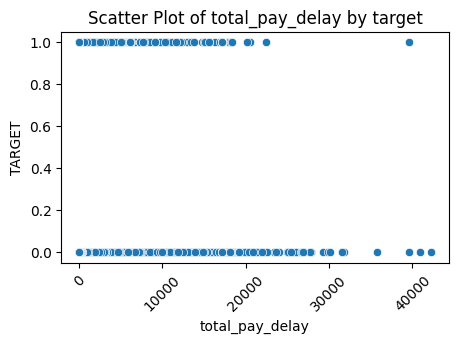

In [31]:
# Plot scatter plot
plt.figure(figsize=(5, 3))
sns.scatterplot(y='TARGET', x='total_pay_delay', data=accounts_data_train_eda)
plt.ylabel('TARGET')
plt.xlabel('total_pay_delay')
plt.title('Scatter Plot of total_pay_delay by target')
plt.xticks(rotation=45)
plt.show()


target and loan_amount

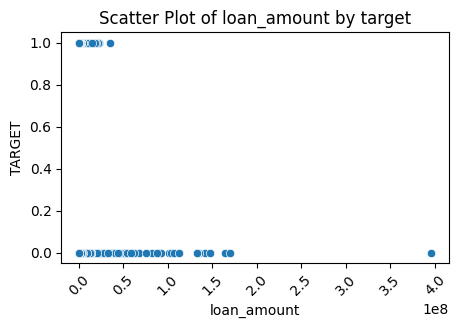

In [30]:
# Plot scatter plot
plt.figure(figsize=(5, 3))
sns.scatterplot(y='TARGET', x='loan_amount', data=accounts_data_train_eda)
plt.ylabel('TARGET')
plt.xlabel('loan_amount')
plt.title('Scatter Plot of loan_amount by target')
plt.xticks(rotation=45)
plt.show()


target and active loans

In [37]:
accounts_data_train_eda["active_loan"] = accounts_data_train_eda['closed_date'].progress_apply(lambda x: 0 if isinstance(x, str) else 1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1245310/1245310 [00:00<00:00, 2290494.24it/s]


TARGET            0      1
active_loan               
0            727822  54453
1            419966  43069


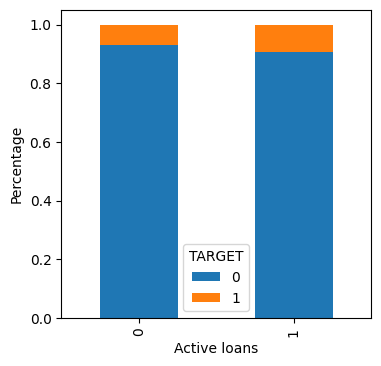

In [38]:
print(pd.crosstab(accounts_data_train_eda["active_loan"],accounts_data_train_eda["TARGET"]))
ct = pd.crosstab(accounts_data_train_eda["active_loan"], accounts_data_train_eda["TARGET"])
ct.div(ct.sum(1).astype(float),axis=0).plot(kind="bar",stacked=True,figsize=(4,4))
plt.xlabel("Active loans")
plt.ylabel("Percentage")
plt.show()

probability of loan being bad loan is 9% if a loan is active and 7% if a loan is closed

target and amount_overdue

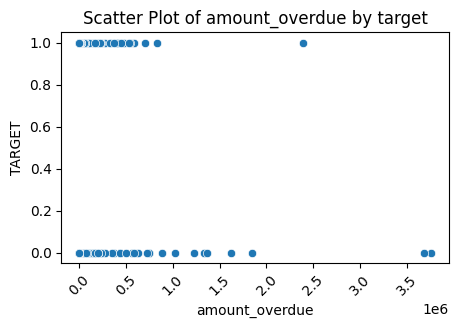

In [41]:
# Plot scatter plot
plt.figure(figsize=(5, 3))
sns.scatterplot(y='TARGET', x='amount_overdue', data=accounts_data_train_eda)
plt.ylabel('TARGET')
plt.xlabel('amount_overdue')
plt.title('Scatter Plot of amount_overdue by target')
plt.xticks(rotation=45)
plt.show()


target and credit type

TARGET                                             0      1
credit_type                                                
Another type of loan                             679     53
Car loan                                       19107   1130
Cash loan (non-earmarked)                         16      1
Consumer credit                               840568  68173
Credit card                                   266673  25749
Interbank credit                                   1      0
Loan for business development                   1380     86
Loan for purchase of shares (margin lending)       4      0
Loan for the purchase of equipment                12      4
Loan for working capital replenishment           278     42
Microloan                                       6172   1594
Mobile operator loan                               1      0
Mortgage                                       12529    667
Real estate loan                                  17      0
Unknown type of loan                    

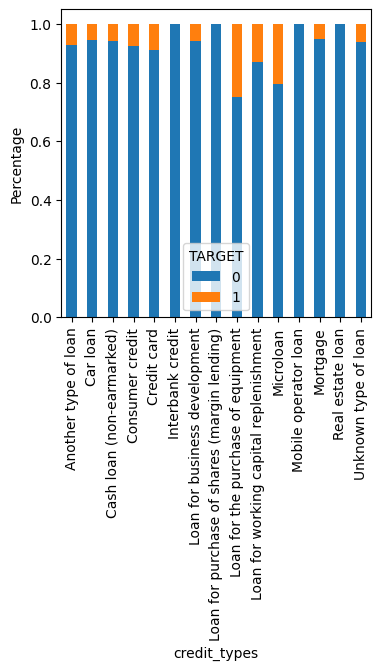

In [42]:
print(pd.crosstab(accounts_data_train_eda["credit_type"],accounts_data_train_eda["TARGET"]))
ct = pd.crosstab(accounts_data_train_eda["credit_type"], accounts_data_train_eda["TARGET"])
ct.div(ct.sum(1).astype(float),axis=0).plot(kind="bar",stacked=True,figsize=(4,4))
plt.xlabel("credit_types")
plt.ylabel("Percentage")
plt.show()

##### corr matrix

In [59]:
accounts_data_train_eda.columns

Index(['credit_type', 'loan_amount', 'amount_overdue', 'open_date',
       'closed_date', 'payment_hist_string', 'uid', 'NAME_CONTRACT_TYPE',
       'TARGET', 'repayment_history', 'total_pay_delay', 'active_loan'],
      dtype='object')

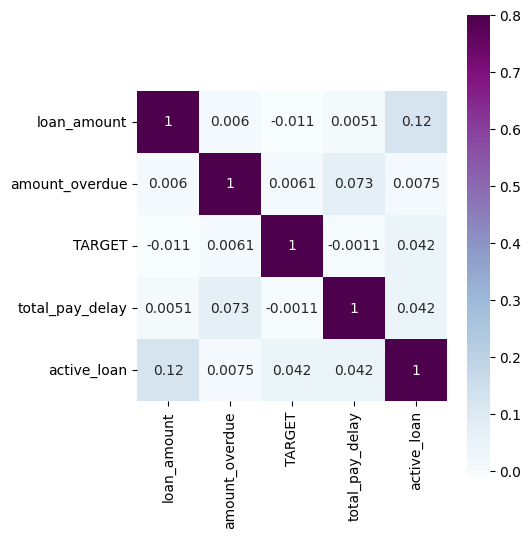

In [62]:
matrix = accounts_data_train_eda.drop(columns=['credit_type', 'uid','open_date',
       'closed_date', 'payment_hist_string', 'NAME_CONTRACT_TYPE', 'repayment_history']).corr()
f, ax = plt.subplots(figsize=(5, 6))
sns.heatmap(matrix, vmax=.8, square=True, cmap="BuPu",annot=True);

#### enquiry data

In [48]:
set(enquiry_data_train['uid']) - set(train_df['uid'])

set()

In [49]:
set(train_df['uid']) - set(enquiry_data_train['uid'])

set()

enquiry_data_train consists all uids

In [44]:
enquiry_data_train_eda = pd.merge(enquiry_data_train, train_df, on='uid', how='left')

In [46]:
enquiry_data_train_eda

,enquiry_type,enquiry_amt,enquiry_date,uid,NAME_CONTRACT_TYPE,TARGET
0,Interbank credit,168839,2020-11-08,AAA08065248,Revolving loans,0
1,Mobile operator loan,268392,2020-09-20,AAA08065248,Revolving loans,0
2,Mobile operator loan,36082,2020-06-19,AAA08065248,Revolving loans,0
3,Interbank credit,180467,2019-10-22,AAA08065248,Revolving loans,0
4,Cash loan (non-earmarked),227459,2020-05-24,AAA08065248,Revolving loans,0
...,...,...,...,...,...,...
1909921,Loan for the purchase of equipment,401073,2020-02-23,ZZZ93377613,Revolving loans,0
1909922,Consumer credit,224844,2018-06-03,ZZZ93377613,Revolving loans,0
1909923,Loan for purchase of shares (margin lending),416642,2017-10-15,ZZZ93377613,Revolving loans,0
1909924,Loan for purchase of shares (margin lending),22000,2020-08-22,ZZZ93377613,Revolving loans,0


In [47]:
enquiry_data_train_eda.enquiry_type.value_counts()

enquiry_type
Cash loans                                      303108
Revolving loans                                 120181
Mobile operator loan                             99479
Real estate loan                                 99328
Microloan                                        99324
Unknown type of loan                             99280
Loan for purchase of shares (margin lending)     99230
Mortgage                                         99216
Credit card                                      99208
Another type of loan                             99154
Loan for the purchase of equipment               99152
Interbank credit                                 99063
Car loan                                         98994
Loan for business development                    98900
Cash loan (non-earmarked)                        98831
Loan for working capital replenishment           98814
Consumer credit                                  98664
Name: count, dtype: int64

target and enquiry type

In [53]:
print(pd.crosstab(enquiry_data_train_eda["enquiry_type"],enquiry_data_train_eda["TARGET"]))

TARGET                                             0      1
enquiry_type                                               
Another type of loan                           91038   8116
Car loan                                       90781   8213
Cash loan (non-earmarked)                      90879   7952
Cash loans                                    278396  24712
Consumer credit                                90729   7935
Credit card                                    90992   8216
Interbank credit                               91067   7996
Loan for business development                  90943   7957
Loan for purchase of shares (margin lending)   91081   8149
Loan for the purchase of equipment             91123   8029
Loan for working capital replenishment         90772   8042
Microloan                                      91257   8067
Mobile operator loan                           91414   8065
Mortgage                                       91219   7997
Real estate loan                        

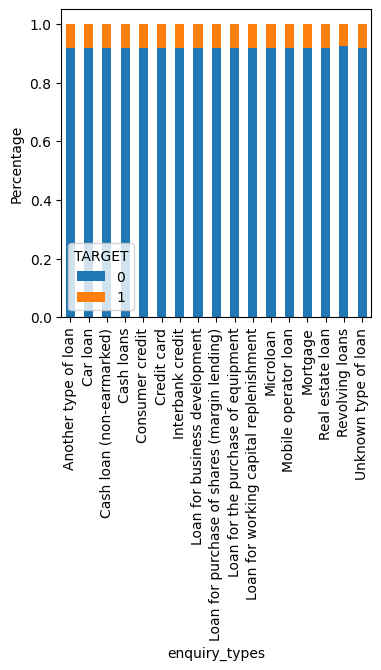

In [54]:
ct = pd.crosstab(enquiry_data_train_eda["enquiry_type"], enquiry_data_train_eda["TARGET"])
ct.div(ct.sum(1).astype(float),axis=0).plot(kind="bar",stacked=True,figsize=(4,4))
plt.xlabel("enquiry_types")
plt.ylabel("Percentage")
plt.show()

In [56]:
enquiry_data_train_eda.columns

Index(['enquiry_type', 'enquiry_amt', 'enquiry_date', 'uid',
       'NAME_CONTRACT_TYPE', 'TARGET'],
      dtype='object')

##### corr matrix

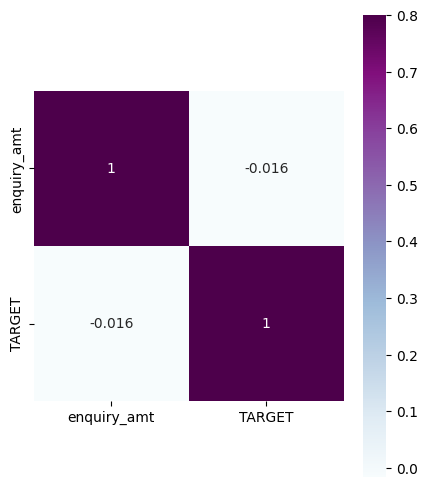

In [63]:
matrix = enquiry_data_train_eda.drop(columns=['enquiry_type','enquiry_date', 'uid',
       'NAME_CONTRACT_TYPE']).corr()
f, ax = plt.subplots(figsize=(5, 6))
sns.heatmap(matrix, vmax=.8, square=True, cmap="BuPu",annot=True);

## Feature engineering

In [70]:
train_df

,uid,NAME_CONTRACT_TYPE,TARGET
0,XDA69787158,Cash loans,0
1,BSE47789733,Cash loans,0
2,NTJ92213825,Cash loans,0
3,TCQ47571695,Cash loans,0
4,WJZ68772744,Cash loans,0
...,...,...,...
261378,BAO14050568,Cash loans,0
261379,NDO00278120,Cash loans,0
261380,LDY78194712,Cash loans,0
261381,EVH98380736,Revolving loans,0


In [71]:
train_df['TARGET'].value_counts()

TARGET
0    240326
1     21057
Name: count, dtype: int64

#### a. accounts_data_train

check if accounts_data_train has uids specified in the train flag file

In [72]:
set(accounts_data_train['uid']) - set(train_df['uid'])

set()

In [73]:
accounts_data_train

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
0,Consumer credit,272745.000,0.0,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550
1,Consumer credit,4500.000,0.0,2018-03-08,2019-07-25,000000000000000014044000000000000000000000000000,AAA09044550
2,Credit card,80996.445,0.0,2020-06-29,NaN,000000000000000000,AAA10545297
3,Consumer credit,43771.500,0.0,2020-06-09,2020-09-09,000000000,AAA14112888
4,Credit card,10480.500,0.0,2014-09-10,NaN,0000000000000000000000000000000000000000000000...,AAA20326915
...,...,...,...,...,...,...,...
1245305,Consumer credit,100116.000,0.0,2017-05-12,2017-06-15,000,ZZZ93377613
1245306,Consumer credit,34839.000,0.0,2016-11-11,2017-12-17,000000000000000000000000000000000000000,ZZZ93377613
1245307,Consumer credit,18589.500,0.0,2015-12-10,2016-05-12,000000000000000,ZZZ93377613
1245308,Consumer credit,24997.500,0.0,2020-09-19,NaN,000000000,ZZZ93377613


##### creating features

In [74]:
accounts_data_train['loan_amount'] = accounts_data_train['loan_amount'].fillna(0)

column to check if the loan is closed or not

In [75]:
accounts_data_train['active_loan'] = accounts_data_train['closed_date'].progress_apply(lambda x: 0 if isinstance(x, str) else 1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1245310/1245310 [00:00<00:00, 2263616.35it/s]


creating column to view the speed of repayment done by the candidate

In [76]:
accounts_data_train['open_date_'] = pd.to_datetime(accounts_data_train['open_date'])

In [77]:
accounts_data_train['closed_date_'] = pd.to_datetime(accounts_data_train['closed_date'])

In [78]:
accounts_data_train['duration'] = (accounts_data_train['closed_date_'] - accounts_data_train['open_date_']).dt.days

In [79]:
accounts_data_train['duration']

0          518.0
1          504.0
2            NaN
3           92.0
4            NaN
           ...  
1245305     34.0
1245306    401.0
1245307    154.0
1245308      NaN
1245309    314.0
Name: duration, Length: 1245310, dtype: float64

In [80]:
accounts_data_train['payment_speed'] = accounts_data_train['loan_amount']/accounts_data_train['duration']
accounts_data_train['payment_speed']

0           526.534749
1             8.928571
2                  NaN
3           475.777174
4                  NaN
              ...     
1245305    2944.588235
1245306      86.880299
1245307     120.711039
1245308            NaN
1245309      66.210191
Name: payment_speed, Length: 1245310, dtype: float64

percentage of over due to the loan amount

In [81]:
accounts_data_train['overdue_percent'] = accounts_data_train['amount_overdue']*100/accounts_data_train['loan_amount']


get information from the payment history replayment 

In [82]:
%%time
accounts_data_train['repayment_history'] = accounts_data_train['payment_hist_string'].progress_apply(get_repayment_history)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1245310/1245310 [00:03<00:00, 313227.45it/s]

CPU times: user 3.94 s, sys: 59.2 ms, total: 4 s
Wall time: 4 s


create  pay delays column

In [83]:
accounts_data_train['total_pay_delay'] = accounts_data_train['repayment_history'].progress_apply(lambda x: sum(x))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1245310/1245310 [00:00<00:00, 2089841.89it/s]


In [84]:
accounts_data_train.columns


Index(['credit_type', 'loan_amount', 'amount_overdue', 'open_date',
       'closed_date', 'payment_hist_string', 'uid', 'active_loan',
       'open_date_', 'closed_date_', 'duration', 'payment_speed',
       'overdue_percent', 'repayment_history', 'total_pay_delay'],
      dtype='object')

In [85]:
accounts_data_train_grp = accounts_data_train.groupby(['uid','active_loan']).aggregate({
    'payment_speed':'mean',
    'loan_amount': 'sum',
    'overdue_percent': 'mean',
    'total_pay_delay': 'sum'
})

accounts_data_train_grp = accounts_data_train_grp.unstack('active_loan')
new_columns = [f'{level1}_{level2}' for level1, level2 in accounts_data_train_grp.columns]
accounts_data_train_grp.columns = new_columns

accounts_data_train_grp=accounts_data_train_grp.reset_index()

In [86]:
accounts_data_train_grp

,uid,payment_speed_0,payment_speed_1,loan_amount_0,loan_amount_1,overdue_percent_0,overdue_percent_1,total_pay_delay_0,total_pay_delay_1
0,AAA09044550,267.731660,NaN,277245.0,NaN,0.0,NaN,68.0,NaN
1,AAA10545297,NaN,NaN,NaN,80996.445,NaN,0.00000,NaN,0.0
2,AAA14112888,475.777174,NaN,43771.5,NaN,0.0,NaN,0.0,NaN
3,AAA20326915,1914.973331,NaN,489496.5,102100.500,0.0,0.00000,0.0,14477.0
4,AAA31604840,333.097092,NaN,346810.5,1245150.000,0.0,0.00000,0.0,0.0
...,...,...,...,...,...,...,...,...,...
223913,ZZZ74526004,219.336397,NaN,113593.5,NaN,0.0,NaN,36.0,NaN
223914,ZZZ78449185,421.926570,NaN,649840.5,NaN,0.0,NaN,4.0,NaN
223915,ZZZ79008454,1117.088235,NaN,170914.5,4845150.000,0.0,2.91117,0.0,37.0
223916,ZZZ81253108,4624.716636,NaN,2529720.0,2808000.000,0.0,0.00000,0.0,66.0


##### separate dataframe for credit types

In [87]:
accounts_data_train['data'] = 1
cred_type_data = accounts_data_train.pivot_table(values='data',index='uid',aggfunc='max',columns='credit_type').reset_index()
new_cols = [i+'_cred_type' for i in cred_type_data.columns]
cred_type_data.columns = new_cols

In [88]:
cred_type_data

,uid_cred_type,Another type of loan_cred_type,Car loan_cred_type,Cash loan (non-earmarked)_cred_type,Consumer credit_cred_type,Credit card_cred_type,Interbank credit_cred_type,Loan for business development_cred_type,Loan for purchase of shares (margin lending)_cred_type,Loan for the purchase of equipment_cred_type,Loan for working capital replenishment_cred_type,Microloan_cred_type,Mobile operator loan_cred_type,Mortgage_cred_type,Real estate loan_cred_type,Unknown type of loan_cred_type
0,AAA09044550,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAA10545297,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAA14112888,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAA20326915,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAA31604840,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223913,ZZZ74526004,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223914,ZZZ78449185,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223915,ZZZ79008454,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223916,ZZZ81253108,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


merging both dataframes of accounts data

In [89]:
accounts_data_train_grp = accounts_data_train_grp.merge(cred_type_data,left_on='uid',right_on='uid_cred_type')
accounts_data_train_grp

,uid,payment_speed_0,payment_speed_1,loan_amount_0,loan_amount_1,overdue_percent_0,overdue_percent_1,total_pay_delay_0,total_pay_delay_1,uid_cred_type,...,Interbank credit_cred_type,Loan for business development_cred_type,Loan for purchase of shares (margin lending)_cred_type,Loan for the purchase of equipment_cred_type,Loan for working capital replenishment_cred_type,Microloan_cred_type,Mobile operator loan_cred_type,Mortgage_cred_type,Real estate loan_cred_type,Unknown type of loan_cred_type
0,AAA09044550,267.731660,NaN,277245.0,NaN,0.0,NaN,68.0,NaN,AAA09044550,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAA10545297,NaN,NaN,NaN,80996.445,NaN,0.00000,NaN,0.0,AAA10545297,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAA14112888,475.777174,NaN,43771.5,NaN,0.0,NaN,0.0,NaN,AAA14112888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAA20326915,1914.973331,NaN,489496.5,102100.500,0.0,0.00000,0.0,14477.0,AAA20326915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAA31604840,333.097092,NaN,346810.5,1245150.000,0.0,0.00000,0.0,0.0,AAA31604840,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223913,ZZZ74526004,219.336397,NaN,113593.5,NaN,0.0,NaN,36.0,NaN,ZZZ74526004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223914,ZZZ78449185,421.926570,NaN,649840.5,NaN,0.0,NaN,4.0,NaN,ZZZ78449185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223915,ZZZ79008454,1117.088235,NaN,170914.5,4845150.000,0.0,2.91117,0.0,37.0,ZZZ79008454,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223916,ZZZ81253108,4624.716636,NaN,2529720.0,2808000.000,0.0,0.00000,0.0,66.0,ZZZ81253108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
accounts_data_train_grp.columns

Index(['uid', 'payment_speed_0', 'payment_speed_1', 'loan_amount_0',
       'loan_amount_1', 'overdue_percent_0', 'overdue_percent_1',
       'total_pay_delay_0', 'total_pay_delay_1', 'uid_cred_type',
       'Another type of loan_cred_type', 'Car loan_cred_type',
       'Cash loan (non-earmarked)_cred_type', 'Consumer credit_cred_type',
       'Credit card_cred_type', 'Interbank credit_cred_type',
       'Loan for business development_cred_type',
       'Loan for purchase of shares (margin lending)_cred_type',
       'Loan for the purchase of equipment_cred_type',
       'Loan for working capital replenishment_cred_type',
       'Microloan_cred_type', 'Mobile operator loan_cred_type',
       'Mortgage_cred_type', 'Real estate loan_cred_type',
       'Unknown type of loan_cred_type'],
      dtype='object')

In [91]:
accounts_data_train_grp = accounts_data_train_grp.drop(columns=['payment_speed_1', 'uid_cred_type'])

In [92]:
accounts_data_train_grp

,uid,payment_speed_0,loan_amount_0,loan_amount_1,overdue_percent_0,overdue_percent_1,total_pay_delay_0,total_pay_delay_1,Another type of loan_cred_type,Car loan_cred_type,...,Interbank credit_cred_type,Loan for business development_cred_type,Loan for purchase of shares (margin lending)_cred_type,Loan for the purchase of equipment_cred_type,Loan for working capital replenishment_cred_type,Microloan_cred_type,Mobile operator loan_cred_type,Mortgage_cred_type,Real estate loan_cred_type,Unknown type of loan_cred_type
0,AAA09044550,267.731660,277245.0,NaN,0.0,NaN,68.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAA10545297,NaN,NaN,80996.445,NaN,0.00000,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAA14112888,475.777174,43771.5,NaN,0.0,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAA20326915,1914.973331,489496.5,102100.500,0.0,0.00000,0.0,14477.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAA31604840,333.097092,346810.5,1245150.000,0.0,0.00000,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223913,ZZZ74526004,219.336397,113593.5,NaN,0.0,NaN,36.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223914,ZZZ78449185,421.926570,649840.5,NaN,0.0,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223915,ZZZ79008454,1117.088235,170914.5,4845150.000,0.0,2.91117,0.0,37.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223916,ZZZ81253108,4624.716636,2529720.0,2808000.000,0.0,0.00000,0.0,66.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### b. enquiry data

In [93]:
enquiry_data_train

,enquiry_type,enquiry_amt,enquiry_date,uid
0,Interbank credit,168839,2020-11-08,AAA08065248
1,Mobile operator loan,268392,2020-09-20,AAA08065248
2,Mobile operator loan,36082,2020-06-19,AAA08065248
3,Interbank credit,180467,2019-10-22,AAA08065248
4,Cash loan (non-earmarked),227459,2020-05-24,AAA08065248
...,...,...,...,...
1909921,Loan for the purchase of equipment,401073,2020-02-23,ZZZ93377613
1909922,Consumer credit,224844,2018-06-03,ZZZ93377613
1909923,Loan for purchase of shares (margin lending),416642,2017-10-15,ZZZ93377613
1909924,Loan for purchase of shares (margin lending),22000,2020-08-22,ZZZ93377613


In [94]:
enquiry_data_train['enquiry_type'].value_counts()

enquiry_type
Cash loans                                      303108
Revolving loans                                 120181
Mobile operator loan                             99479
Real estate loan                                 99328
Microloan                                        99324
Unknown type of loan                             99280
Loan for purchase of shares (margin lending)     99230
Mortgage                                         99216
Credit card                                      99208
Another type of loan                             99154
Loan for the purchase of equipment               99152
Interbank credit                                 99063
Car loan                                         98994
Loan for business development                    98900
Cash loan (non-earmarked)                        98831
Loan for working capital replenishment           98814
Consumer credit                                  98664
Name: count, dtype: int64

In [95]:
enquiry_data_train['enquiry_days'] = (pd.to_datetime('today') - pd.to_datetime(enquiry_data_train['enquiry_date'])).dt.days

In [96]:
enquiry_data_train.dtypes

enquiry_type    object
enquiry_amt      int64
enquiry_date    object
uid             object
enquiry_days     int64
dtype: object

In [97]:
enquiry_data_train['enquiry_days'] = enquiry_data_train['enquiry_days'].astype(int)

In [98]:
enquiry_data_train['enquiry_amt']=enquiry_data_train['enquiry_amt'].astype(float)

In [99]:
enquiry_data_train_grp = enquiry_data_train.groupby('uid').aggregate({
    'enquiry_days':'mean',
    'enquiry_amt':'mean'
}).reset_index()

enquiry_data_train_grp

,uid,enquiry_days,enquiry_amt
0,AAA08065248,1445.909091,187696.181818
1,AAA09044550,1455.538462,102269.230769
2,AAA10545297,1525.142857,94071.428571
3,AAA14112888,1628.400000,97666.666667
4,AAA20326915,1306.000000,66000.000000
...,...,...,...
261378,ZZZ74526004,1616.625000,112250.000000
261379,ZZZ78449185,1280.666667,359326.833333
261380,ZZZ79008454,1289.000000,28000.000000
261381,ZZZ81253108,1413.241379,103551.724138


In [100]:
enquiry_data_train['data'] = 1
enquiry_type_data = enquiry_data_train.pivot_table(values='data',index='uid',aggfunc='max',columns='enquiry_type').reset_index()
new_cols = [i+'_enquiry_type' for i in enquiry_type_data.columns]
enquiry_type_data.columns = new_cols

In [101]:
enquiry_type_data

,uid_enquiry_type,Another type of loan_enquiry_type,Car loan_enquiry_type,Cash loan (non-earmarked)_enquiry_type,Cash loans_enquiry_type,Consumer credit_enquiry_type,Credit card_enquiry_type,Interbank credit_enquiry_type,Loan for business development_enquiry_type,Loan for purchase of shares (margin lending)_enquiry_type,Loan for the purchase of equipment_enquiry_type,Loan for working capital replenishment_enquiry_type,Microloan_enquiry_type,Mobile operator loan_enquiry_type,Mortgage_enquiry_type,Real estate loan_enquiry_type,Revolving loans_enquiry_type,Unknown type of loan_enquiry_type
0,AAA08065248,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN
1,AAA09044550,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0
2,AAA10545297,1.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
3,AAA14112888,1.0,NaN,1.0,1.0,1.0,NaN,1.0,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,1.0
4,AAA20326915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261378,ZZZ74526004,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN
261379,ZZZ78449185,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN
261380,ZZZ79008454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
261381,ZZZ81253108,1.0,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0


In [102]:
enquiry_data_train_grp = enquiry_data_train_grp.merge(enquiry_type_data,left_on='uid',right_on='uid_enquiry_type')
enquiry_data_train_grp

,uid,enquiry_days,enquiry_amt,uid_enquiry_type,Another type of loan_enquiry_type,Car loan_enquiry_type,Cash loan (non-earmarked)_enquiry_type,Cash loans_enquiry_type,Consumer credit_enquiry_type,Credit card_enquiry_type,...,Loan for business development_enquiry_type,Loan for purchase of shares (margin lending)_enquiry_type,Loan for the purchase of equipment_enquiry_type,Loan for working capital replenishment_enquiry_type,Microloan_enquiry_type,Mobile operator loan_enquiry_type,Mortgage_enquiry_type,Real estate loan_enquiry_type,Revolving loans_enquiry_type,Unknown type of loan_enquiry_type
0,AAA08065248,1445.909091,187696.181818,AAA08065248,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN
1,AAA09044550,1455.538462,102269.230769,AAA09044550,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0
2,AAA10545297,1525.142857,94071.428571,AAA10545297,1.0,NaN,1.0,1.0,1.0,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
3,AAA14112888,1628.400000,97666.666667,AAA14112888,1.0,NaN,1.0,1.0,1.0,NaN,...,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,1.0
4,AAA20326915,1306.000000,66000.000000,AAA20326915,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261378,ZZZ74526004,1616.625000,112250.000000,ZZZ74526004,NaN,NaN,NaN,1.0,1.0,NaN,...,1.0,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN
261379,ZZZ78449185,1280.666667,359326.833333,ZZZ78449185,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,1.0,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN
261380,ZZZ79008454,1289.000000,28000.000000,ZZZ79008454,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
261381,ZZZ81253108,1413.241379,103551.724138,ZZZ81253108,1.0,1.0,NaN,1.0,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0


In [103]:
enquiry_data_train_grp.columns

Index(['uid', 'enquiry_days', 'enquiry_amt', 'uid_enquiry_type',
       'Another type of loan_enquiry_type', 'Car loan_enquiry_type',
       'Cash loan (non-earmarked)_enquiry_type', 'Cash loans_enquiry_type',
       'Consumer credit_enquiry_type', 'Credit card_enquiry_type',
       'Interbank credit_enquiry_type',
       'Loan for business development_enquiry_type',
       'Loan for purchase of shares (margin lending)_enquiry_type',
       'Loan for the purchase of equipment_enquiry_type',
       'Loan for working capital replenishment_enquiry_type',
       'Microloan_enquiry_type', 'Mobile operator loan_enquiry_type',
       'Mortgage_enquiry_type', 'Real estate loan_enquiry_type',
       'Revolving loans_enquiry_type', 'Unknown type of loan_enquiry_type'],
      dtype='object')

In [104]:
enquiry_data_train_grp = enquiry_data_train_grp.drop(columns=['uid_enquiry_type'])

#### c. combining both application and enquiry data

In [105]:
train_data = train_df.merge(enquiry_data_train_grp, on='uid', how='left')

In [106]:
train_data = train_data.merge(accounts_data_train_grp, on='uid', how='left')

In [107]:
train_data

,uid,NAME_CONTRACT_TYPE,TARGET,enquiry_days,enquiry_amt,Another type of loan_enquiry_type,Car loan_enquiry_type,Cash loan (non-earmarked)_enquiry_type,Cash loans_enquiry_type,Consumer credit_enquiry_type,...,Interbank credit_cred_type,Loan for business development_cred_type,Loan for purchase of shares (margin lending)_cred_type,Loan for the purchase of equipment_cred_type,Loan for working capital replenishment_cred_type,Microloan_cred_type,Mobile operator loan_cred_type,Mortgage_cred_type,Real estate loan_cred_type,Unknown type of loan_cred_type
0,XDA69787158,Cash loans,0,1315.500000,135500.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BSE47789733,Cash loans,0,1323.333333,144333.333333,NaN,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NTJ92213825,Cash loans,0,1523.750000,120500.000000,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TCQ47571695,Cash loans,0,1258.000000,148000.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,WJZ68772744,Cash loans,0,1447.818182,110318.181818,1.0,1.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261378,BAO14050568,Cash loans,0,1485.687500,102500.000000,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261379,NDO00278120,Cash loans,0,1552.133333,89600.000000,1.0,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261380,LDY78194712,Cash loans,0,1398.403846,109115.384615,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261381,EVH98380736,Revolving loans,0,1187.000000,206231.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [108]:
train_data = train_data.fillna(0)

In [109]:
train_data

,uid,NAME_CONTRACT_TYPE,TARGET,enquiry_days,enquiry_amt,Another type of loan_enquiry_type,Car loan_enquiry_type,Cash loan (non-earmarked)_enquiry_type,Cash loans_enquiry_type,Consumer credit_enquiry_type,...,Interbank credit_cred_type,Loan for business development_cred_type,Loan for purchase of shares (margin lending)_cred_type,Loan for the purchase of equipment_cred_type,Loan for working capital replenishment_cred_type,Microloan_cred_type,Mobile operator loan_cred_type,Mortgage_cred_type,Real estate loan_cred_type,Unknown type of loan_cred_type
0,XDA69787158,Cash loans,0,1315.500000,135500.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BSE47789733,Cash loans,0,1323.333333,144333.333333,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NTJ92213825,Cash loans,0,1523.750000,120500.000000,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TCQ47571695,Cash loans,0,1258.000000,148000.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,WJZ68772744,Cash loans,0,1447.818182,110318.181818,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261378,BAO14050568,Cash loans,0,1485.687500,102500.000000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
261379,NDO00278120,Cash loans,0,1552.133333,89600.000000,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
261380,LDY78194712,Cash loans,0,1398.403846,109115.384615,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
261381,EVH98380736,Revolving loans,0,1187.000000,206231.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### plotting distribution plots for loan and enquiry amount columns

In [110]:
columns = ['enquiry_amt', 'loan_amount_1', 'loan_amount_0']

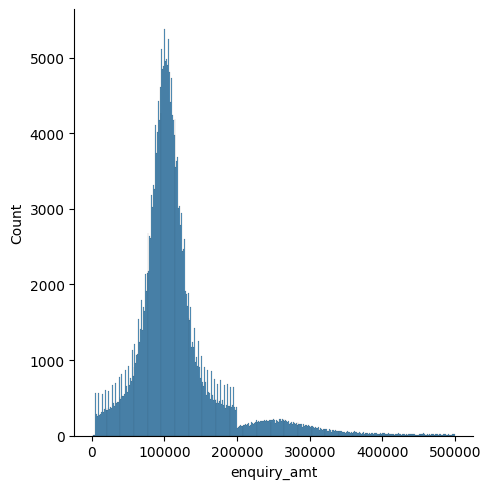

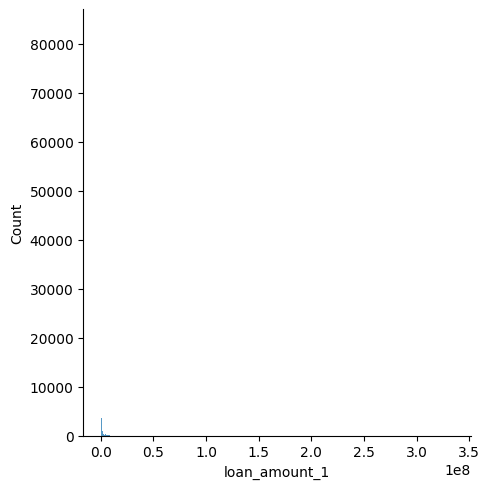

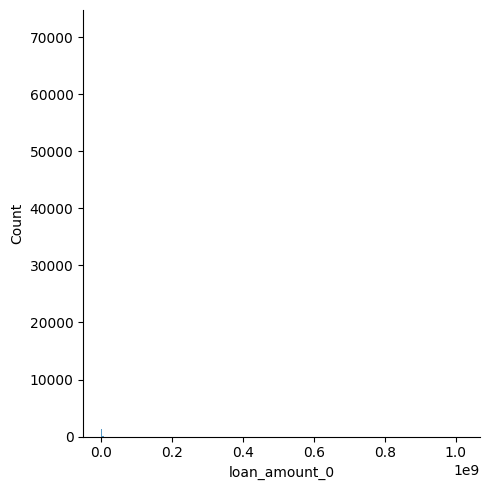

In [111]:
[sns.displot(train_data[col]) for col in columns]

/Users/krakesh.kumar/miniconda3/envs/llm_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/krakesh.kumar/miniconda3/envs/llm_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


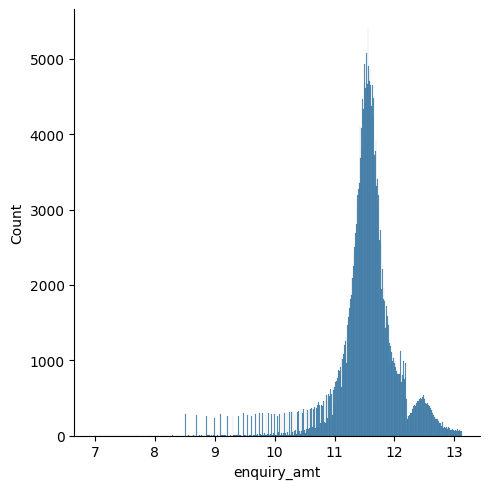

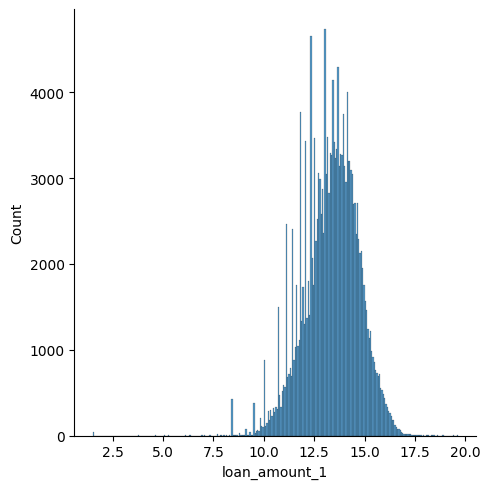

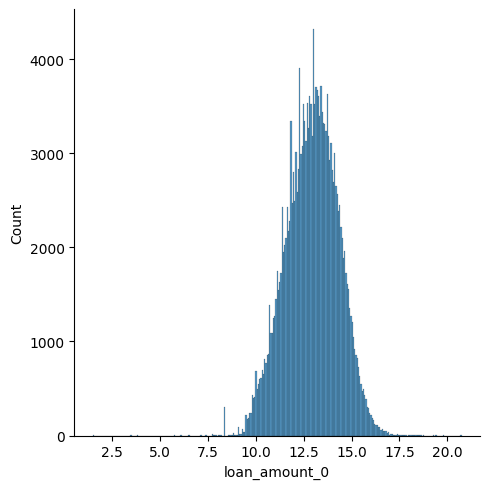

In [112]:
[sns.displot(np.log(train_data[col])) for col in columns]

In [113]:
for col in columns:
    train_data[col] = np.log(train_data[col])

/Users/krakesh.kumar/miniconda3/envs/llm_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [114]:
train_data[columns] = train_data[columns].replace([np.inf, -np.inf,np.nan], 0)

In [115]:
train_data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [116]:
train_data

,uid,NAME_CONTRACT_TYPE,TARGET,enquiry_days,enquiry_amt,Another type of loan_enquiry_type,Car loan_enquiry_type,Cash loan (non-earmarked)_enquiry_type,Cash loans_enquiry_type,Consumer credit_enquiry_type,...,Interbank credit_cred_type,Loan for business development_cred_type,Loan for purchase of shares (margin lending)_cred_type,Loan for the purchase of equipment_cred_type,Loan for working capital replenishment_cred_type,Microloan_cred_type,Mobile operator loan_cred_type,Mortgage_cred_type,Real estate loan_cred_type,Unknown type of loan_cred_type
0,XDA69787158,Cash loans,0,1315.500000,11.816727,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BSE47789733,Cash loans,0,1323.333333,11.879881,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NTJ92213825,Cash loans,0,1523.750000,11.699405,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TCQ47571695,Cash loans,0,1258.000000,11.904968,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,WJZ68772744,Cash loans,0,1447.818182,11.611124,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261378,BAO14050568,Cash loans,0,1485.687500,11.537618,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
261379,NDO00278120,Cash loans,0,1552.133333,11.403111,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
261380,LDY78194712,Cash loans,0,1398.403846,11.600161,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
261381,EVH98380736,Revolving loans,0,1187.000000,12.236752,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [117]:
train_data.columns

Index(['uid', 'NAME_CONTRACT_TYPE', 'TARGET', 'enquiry_days', 'enquiry_amt',
       'Another type of loan_enquiry_type', 'Car loan_enquiry_type',
       'Cash loan (non-earmarked)_enquiry_type', 'Cash loans_enquiry_type',
       'Consumer credit_enquiry_type', 'Credit card_enquiry_type',
       'Interbank credit_enquiry_type',
       'Loan for business development_enquiry_type',
       'Loan for purchase of shares (margin lending)_enquiry_type',
       'Loan for the purchase of equipment_enquiry_type',
       'Loan for working capital replenishment_enquiry_type',
       'Microloan_enquiry_type', 'Mobile operator loan_enquiry_type',
       'Mortgage_enquiry_type', 'Real estate loan_enquiry_type',
       'Revolving loans_enquiry_type', 'Unknown type of loan_enquiry_type',
       'payment_speed_0', 'loan_amount_0', 'loan_amount_1',
       'overdue_percent_0', 'overdue_percent_1', 'total_pay_delay_0',
       'total_pay_delay_1', 'Another type of loan_cred_type',
       'Car loan_cred_type'

## Train Val spliting

In [118]:
from sklearn.model_selection import train_test_split

In [119]:
X = train_data.drop(columns = ['uid', 'NAME_CONTRACT_TYPE', 'TARGET'])
y = train_data['TARGET']
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)    


## Modelling

#### 1. Xgboost

In [163]:
# Define the XGBoost classifier
xgb = XGBClassifier()

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.2]
}

# Perform grid search with cross-validation
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_xgb.fit(x_train, y_train)

# Get the best hyperparameters and best score
best_params = grid_search_xgb.best_params_
best_score = grid_search_xgb.best_score_

print("Best Hyperparameters:", best_params)
print("Best Score (ROC AUC):", best_score)


Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Best Score (ROC AUC): 0.659940545694238


#### 2. Logistic Regression

In [136]:
# Standardize the continuous features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train.fillna(0))
X_val_scaled = scaler.transform(x_val.fillna(0))


In [140]:
log_reg = LogisticRegression()

# Define the grid of hyperparameters to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Score (ROC AUC):", best_score)

Best Hyperparameters: {'C': 0.001, 'penalty': 'l2'}
Best Score (ROC AUC): 0.6206577164088288


#### 3. Random Forest

In [146]:
rf = RandomForestClassifier()

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5],
    'min_samples_split': [5, 8],
    'min_samples_leaf': [3, 6]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=  13.1s
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=  14.5s
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=  27.8s
[CV] END max_depth=5, min_samples_leaf=6, min_samples_split=5, n_estimators=200; total time=  27.3s
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=  26.8s
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=  14.2s
[CV] END max_depth=5, min_samples_leaf=6, min_samples_split=5, n_estimators=100; total time=  13.8s
[CV] END max_depth=5, min_samples_leaf=6, min_samples_split=5, n_estimators=100; total time=  13.6s
[CV] END max_depth=5, min_samples_leaf=6, min_samples_split=8, n_estimators=100; total time=  13.6s
[CV] END max_depth=5, min_samples_leaf=6

In [147]:
print("Best Hyperparameters:", best_params)
print("Best Score (ROC AUC):", best_score)

Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 200}
Best Score (ROC AUC): 0.6445845535079668


Xgboost classifier performed better

let's try to increase the score with under and over sampling

### oversampling data

In [148]:
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(random_state=42)
X_over, y_over = over_sampler.fit_resample(x_train, y_train)

In [149]:
X_over

,enquiry_days,enquiry_amt,Another type of loan_enquiry_type,Car loan_enquiry_type,Cash loan (non-earmarked)_enquiry_type,Cash loans_enquiry_type,Consumer credit_enquiry_type,Credit card_enquiry_type,Interbank credit_enquiry_type,Loan for business development_enquiry_type,...,Interbank credit_cred_type,Loan for business development_cred_type,Loan for purchase of shares (margin lending)_cred_type,Loan for the purchase of equipment_cred_type,Loan for working capital replenishment_cred_type,Microloan_cred_type,Mobile operator loan_cred_type,Mortgage_cred_type,Real estate loan_cred_type,Unknown type of loan_cred_type
0,1341.000000,10.532096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1484.857143,12.280127,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1187.000000,11.775290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1372.000000,11.775290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1457.666667,11.684074,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336451,1263.250000,11.827736,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
336452,1389.000000,11.666259,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
336453,1432.400000,11.854385,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
336454,1330.250000,10.928633,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [152]:
# Define the XGBoost classifier
xgb = XGBClassifier()

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100],
    'max_depth': [3],
    'learning_rate': [ 0.2]
}

# Perform grid search with cross-validation
grid_search_over = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_over.fit(X_over, y_over)

# Get the best hyperparameters and best score
best_params = grid_search_over.best_params_
best_score = grid_search_over.best_score_

print("Best Hyperparameters:", best_params)
print("Best Score (ROC AUC):", best_score)


Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Best Score (ROC AUC): 0.6787817998298896


In [159]:
print("Val data Score (ROC AUC):", roc_auc_score(y_val, grid_search_over.best_estimator_.predict(x_val)))

Val data Score (ROC AUC): 0.6143316780675283


### undersampling data

In [153]:
from imblearn.under_sampling import RandomUnderSampler
under_sampler = RandomUnderSampler(random_state=42)
X_under, y_under = under_sampler.fit_resample(x_train, y_train)

In [154]:
X_under

,enquiry_days,enquiry_amt,Another type of loan_enquiry_type,Car loan_enquiry_type,Cash loan (non-earmarked)_enquiry_type,Cash loans_enquiry_type,Consumer credit_enquiry_type,Credit card_enquiry_type,Interbank credit_enquiry_type,Loan for business development_enquiry_type,...,Interbank credit_cred_type,Loan for business development_cred_type,Loan for purchase of shares (margin lending)_cred_type,Loan for the purchase of equipment_cred_type,Loan for working capital replenishment_cred_type,Microloan_cred_type,Mobile operator loan_cred_type,Mortgage_cred_type,Real estate loan_cred_type,Unknown type of loan_cred_type
217640,1420.400000,11.385092,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205438,1325.400000,11.350407,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37061,1403.833333,11.558536,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62650,1501.375000,11.571194,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109255,1473.900000,11.482466,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202176,1644.285714,11.277203,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118247,1698.333333,11.396392,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112420,1500.230769,11.557310,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80015,1451.250000,11.425459,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [160]:
# Define the XGBoost classifier
xgb = XGBClassifier()

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100],
    'max_depth': [3],
    'learning_rate': [0.2]
}

# Perform grid search with cross-validation
grid_search_under = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_under.fit(X_under, y_under)

# Get the best hyperparameters and best score
best_params = grid_search_under.best_params_
best_score = grid_search_under.best_score_

print("Best Hyperparameters:", best_params)
print("Best Score (ROC AUC):", best_score)


Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Best Score (ROC AUC): 0.657495549267355


In [161]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


In [162]:
print("Val data Score (ROC AUC):", roc_auc_score(y_val, grid_search_under.best_estimator_.predict(x_val)))

Val data Score (ROC AUC): 0.6103277736585411


Over sampling gave better accuracy of 68%

### score on train and Val set

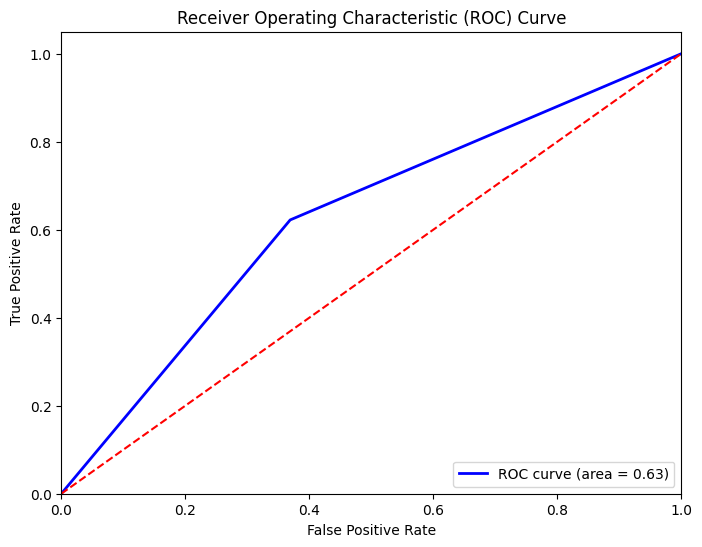

In [167]:

# Compute ROC curve and ROC AUC score
y_pred = grid_search_over.predict(x_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred)
roc_auc = roc_auc_score(y_train, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


#### score on validation set

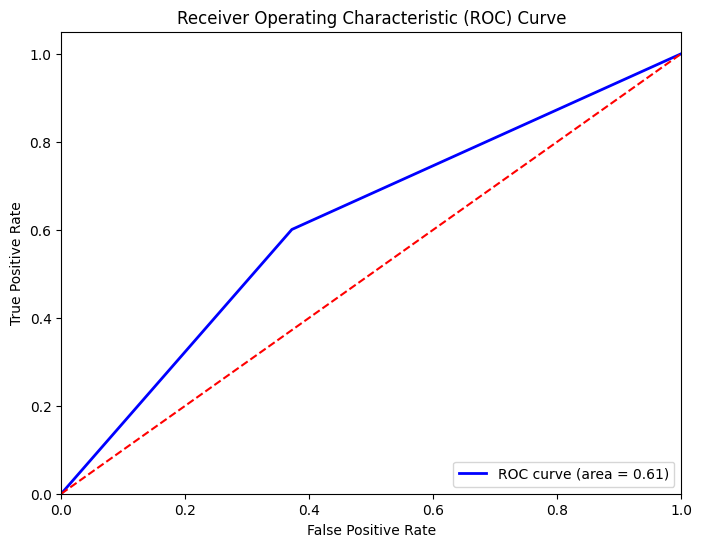

In [168]:
y_pred = grid_search_over.predict(x_val)
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Test Data

In [169]:
test_df = pd.read_csv("data/test/test_flag.csv")

In [170]:
test_df

,uid,NAME_CONTRACT_TYPE
0,CMO22835242,Cash loans
1,MRJ34316727,Cash loans
2,UAV00534378,Cash loans
3,IPQ08190402,Cash loans
4,NQN84331006,Cash loans
...,...,...
46122,IQY03739314,Cash loans
46123,QIL15152190,Cash loans
46124,HMM67531434,Cash loans
46125,WWW87911447,Cash loans


#### a. accounts_data_test

In [171]:
accounts_data_test = dataframe_from_json("data/test/accounts_data_test.json")

check if accounts_data_train has uids specified in the train flag file

In [172]:
accounts_data_test

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
0,Consumer credit,31630.50,0.0,2014-03-30,2014-11-29,000000000000000000000000,AAA14437029
1,Consumer credit,14613.39,0.0,2014-06-01,2014-11-03,000000000000000,AAA14437029
2,Credit card,54000.00,0.0,2015-12-13,2019-09-21,0000000000000000000000000000000000000000000000...,AAA14437029
3,Consumer credit,27076.50,0.0,2015-11-11,2016-11-24,000000000000000000000000000000000000,AAA14437029
4,Credit card,225000.00,0.0,2017-07-15,2019-11-14,0000000000000000000000000000000000000000000000...,AAA14437029
...,...,...,...,...,...,...,...
220008,Credit card,450000.00,0.0,2020-04-16,NaN,000000000000000000000000,ZZZ02221122
220009,Credit card,225000.00,0.0,2020-04-08,NaN,000000000000000000000000,ZZZ02221122
220010,Credit card,0.00,0.0,2017-11-15,2019-06-15,0000000000000000000000000000000000000000000000...,ZZZ02221122
220011,Consumer credit,468000.00,0.0,2018-06-23,NaN,0000000000000000000000000000000020320620921221...,ZZZ02221122


##### creating features

In [173]:
accounts_data_test['loan_amount'] = accounts_data_test['loan_amount'].fillna(0)

column to check if the loan is closed or not

In [174]:
accounts_data_test['active_loan'] = accounts_data_test['closed_date'].progress_apply(lambda x: 0 if isinstance(x, str) else 1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220013/220013 [00:00<00:00, 2200719.75it/s]


creating column to view the speed of repayment done by the candidate

In [175]:
accounts_data_test['open_date_'] = pd.to_datetime(accounts_data_test['open_date'])

In [176]:
accounts_data_test['closed_date_'] = pd.to_datetime(accounts_data_test['closed_date'])

In [177]:
accounts_data_test['duration'] = (accounts_data_test['closed_date_'] - accounts_data_test['open_date_']).dt.days

In [178]:
accounts_data_test['duration']

0          244.0
1          155.0
2         1378.0
3          379.0
4          852.0
           ...  
220008       NaN
220009       NaN
220010     577.0
220011       NaN
220012       NaN
Name: duration, Length: 220013, dtype: float64

In [179]:
accounts_data_test['payment_speed'] = accounts_data_test['loan_amount']/accounts_data_test['duration']
accounts_data_test['payment_speed']

0         129.633197
1          94.279935
2          39.187228
3          71.441953
4         264.084507
             ...    
220008           NaN
220009           NaN
220010      0.000000
220011           NaN
220012           NaN
Name: payment_speed, Length: 220013, dtype: float64

percentage of over due to the loan amount

In [180]:
accounts_data_test['overdue_percent'] = accounts_data_test['amount_overdue']*100/accounts_data_test['loan_amount']


In [181]:
%%time
accounts_data_test['repayment_history'] = accounts_data_test['payment_hist_string'].progress_apply(get_repayment_history)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220013/220013 [00:02<00:00, 79410.45it/s]

CPU times: user 1.79 s, sys: 606 ms, total: 2.39 s
Wall time: 2.78 s


create  pay delays column

In [182]:
accounts_data_test['total_pay_delay'] = accounts_data_test['repayment_history'].progress_apply(lambda x: sum(x))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220013/220013 [00:00<00:00, 1962810.05it/s]


In [183]:
accounts_data_test.columns


Index(['credit_type', 'loan_amount', 'amount_overdue', 'open_date',
       'closed_date', 'payment_hist_string', 'uid', 'active_loan',
       'open_date_', 'closed_date_', 'duration', 'payment_speed',
       'overdue_percent', 'repayment_history', 'total_pay_delay'],
      dtype='object')

In [184]:
accounts_data_test_grp = accounts_data_test.groupby(['uid','active_loan']).aggregate({
    'payment_speed':'mean',
    'loan_amount': 'sum',
    'overdue_percent': 'mean',
    'total_pay_delay': 'sum'
})

accounts_data_test_grp = accounts_data_test_grp.unstack('active_loan')
new_columns = [f'{level1}_{level2}' for level1, level2 in accounts_data_test_grp.columns]
accounts_data_test_grp.columns = new_columns

accounts_data_test_grp=accounts_data_test_grp.reset_index()

In [185]:
accounts_data_test_grp

,uid,payment_speed_0,payment_speed_1,loan_amount_0,loan_amount_1,overdue_percent_0,overdue_percent_1,total_pay_delay_0,total_pay_delay_1
0,AAA14437029,1100.239446,NaN,3635218.890,101097.000,0.0,0.0,1500.0,0.0
1,AAB12915377,250.181209,NaN,45532.980,362475.000,0.0,0.0,42.0,0.0
2,AAB55088883,284.819008,NaN,260808.210,66586.275,0.0,0.0,0.0,0.0
3,AAB68152393,484.950997,NaN,1415236.500,391500.000,0.0,0.0,984.0,0.0
4,AAC29580834,772.928927,NaN,680176.800,2187360.000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
39567,ZZX89351447,468.072078,NaN,427518.000,1410709.500,0.0,0.0,0.0,0.0
39568,ZZX95870699,1289.865561,NaN,3517245.000,2925000.000,0.0,0.0,0.0,0.0
39569,ZZY22936172,752.301684,NaN,465817.725,309838.500,0.0,0.0,0.0,0.0
39570,ZZY83980941,136.873531,NaN,153688.500,NaN,0.0,NaN,0.0,NaN


##### separate dataframe for credit types

In [186]:
accounts_data_test['data'] = 1
cred_type_data = accounts_data_test.pivot_table(values='data',index='uid',aggfunc='max',columns='credit_type').reset_index()
new_cols = [i+'_cred_type' for i in cred_type_data.columns]
cred_type_data.columns = new_cols

In [187]:
cred_type_data

,uid_cred_type,Another type of loan_cred_type,Car loan_cred_type,Cash loan (non-earmarked)_cred_type,Consumer credit_cred_type,Credit card_cred_type,Loan for business development_cred_type,Loan for the purchase of equipment_cred_type,Loan for working capital replenishment_cred_type,Microloan_cred_type,Mortgage_cred_type,Real estate loan_cred_type,Unknown type of loan_cred_type
0,AAA14437029,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAB12915377,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAB55088883,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAB68152393,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAC29580834,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39567,ZZX89351447,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39568,ZZX95870699,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39569,ZZY22936172,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39570,ZZY83980941,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


merging both dataframes of accounts data

In [188]:
accounts_data_test_grp = accounts_data_test_grp.merge(cred_type_data,left_on='uid',right_on='uid_cred_type')
accounts_data_test_grp

,uid,payment_speed_0,payment_speed_1,loan_amount_0,loan_amount_1,overdue_percent_0,overdue_percent_1,total_pay_delay_0,total_pay_delay_1,uid_cred_type,...,Cash loan (non-earmarked)_cred_type,Consumer credit_cred_type,Credit card_cred_type,Loan for business development_cred_type,Loan for the purchase of equipment_cred_type,Loan for working capital replenishment_cred_type,Microloan_cred_type,Mortgage_cred_type,Real estate loan_cred_type,Unknown type of loan_cred_type
0,AAA14437029,1100.239446,NaN,3635218.890,101097.000,0.0,0.0,1500.0,0.0,AAA14437029,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAB12915377,250.181209,NaN,45532.980,362475.000,0.0,0.0,42.0,0.0,AAB12915377,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAB55088883,284.819008,NaN,260808.210,66586.275,0.0,0.0,0.0,0.0,AAB55088883,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAB68152393,484.950997,NaN,1415236.500,391500.000,0.0,0.0,984.0,0.0,AAB68152393,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAC29580834,772.928927,NaN,680176.800,2187360.000,0.0,0.0,0.0,0.0,AAC29580834,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39567,ZZX89351447,468.072078,NaN,427518.000,1410709.500,0.0,0.0,0.0,0.0,ZZX89351447,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39568,ZZX95870699,1289.865561,NaN,3517245.000,2925000.000,0.0,0.0,0.0,0.0,ZZX95870699,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39569,ZZY22936172,752.301684,NaN,465817.725,309838.500,0.0,0.0,0.0,0.0,ZZY22936172,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39570,ZZY83980941,136.873531,NaN,153688.500,NaN,0.0,NaN,0.0,NaN,ZZY83980941,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [189]:
accounts_data_test_grp.columns

Index(['uid', 'payment_speed_0', 'payment_speed_1', 'loan_amount_0',
       'loan_amount_1', 'overdue_percent_0', 'overdue_percent_1',
       'total_pay_delay_0', 'total_pay_delay_1', 'uid_cred_type',
       'Another type of loan_cred_type', 'Car loan_cred_type',
       'Cash loan (non-earmarked)_cred_type', 'Consumer credit_cred_type',
       'Credit card_cred_type', 'Loan for business development_cred_type',
       'Loan for the purchase of equipment_cred_type',
       'Loan for working capital replenishment_cred_type',
       'Microloan_cred_type', 'Mortgage_cred_type',
       'Real estate loan_cred_type', 'Unknown type of loan_cred_type'],
      dtype='object')

In [190]:
accounts_data_test_grp = accounts_data_test_grp.drop(columns=['payment_speed_1', 'uid_cred_type'])

In [191]:
accounts_data_test_grp

,uid,payment_speed_0,loan_amount_0,loan_amount_1,overdue_percent_0,overdue_percent_1,total_pay_delay_0,total_pay_delay_1,Another type of loan_cred_type,Car loan_cred_type,Cash loan (non-earmarked)_cred_type,Consumer credit_cred_type,Credit card_cred_type,Loan for business development_cred_type,Loan for the purchase of equipment_cred_type,Loan for working capital replenishment_cred_type,Microloan_cred_type,Mortgage_cred_type,Real estate loan_cred_type,Unknown type of loan_cred_type
0,AAA14437029,1100.239446,3635218.890,101097.000,0.0,0.0,1500.0,0.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAB12915377,250.181209,45532.980,362475.000,0.0,0.0,42.0,0.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAB55088883,284.819008,260808.210,66586.275,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAB68152393,484.950997,1415236.500,391500.000,0.0,0.0,984.0,0.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAC29580834,772.928927,680176.800,2187360.000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39567,ZZX89351447,468.072078,427518.000,1410709.500,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39568,ZZX95870699,1289.865561,3517245.000,2925000.000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39569,ZZY22936172,752.301684,465817.725,309838.500,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39570,ZZY83980941,136.873531,153688.500,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### b. enquiry data

In [192]:
enquiry_data_test = dataframe_from_json("data/test/enquiry_data_test.json")

In [193]:
enquiry_data_test

,enquiry_type,enquiry_amt,enquiry_date,uid
0,Car loan,143000,2020-12-13,AAA02107680
1,Real estate loan,174000,2020-12-01,AAA14437029
2,Loan for working capital replenishment,65000,2019-07-01,AAA14437029
3,Loan for working capital replenishment,118000,2020-08-05,AAA14437029
4,Car loan,12000,2020-02-28,AAA14437029
...,...,...,...,...
337657,Unknown type of loan,199000,2020-11-08,ZZZ02221122
337658,Revolving loans,145000,2020-10-16,ZZZ02221122
337659,Another type of loan,93000,2020-02-10,ZZZ02221122
337660,Mortgage,119000,2020-04-08,ZZZ02221122


In [194]:
enquiry_data_test['enquiry_type'].value_counts()

enquiry_type
Cash loans                                      53125
Revolving loans                                 21168
Car loan                                        17894
Credit card                                     17701
Another type of loan                            17619
Real estate loan                                17618
Mobile operator loan                            17599
Microloan                                       17589
Loan for purchase of shares (margin lending)    17575
Unknown type of loan                            17524
Loan for business development                   17523
Loan for working capital replenishment          17511
Mortgage                                        17504
Cash loan (non-earmarked)                       17467
Loan for the purchase of equipment              17467
Interbank credit                                17393
Consumer credit                                 17385
Name: count, dtype: int64

In [195]:
enquiry_data_test['enquiry_days'] = (pd.to_datetime('today') - pd.to_datetime(enquiry_data_test['enquiry_date'])).dt.days

In [196]:
enquiry_data_test.dtypes

enquiry_type    object
enquiry_amt      int64
enquiry_date    object
uid             object
enquiry_days     int64
dtype: object

In [197]:
enquiry_data_test['enquiry_days'] = enquiry_data_test['enquiry_days'].astype(int)

In [198]:
enquiry_data_test['enquiry_amt']=enquiry_data_test['enquiry_amt'].astype(float)

In [199]:
enquiry_data_test_grp = enquiry_data_test.groupby('uid').aggregate({
    'enquiry_days':'mean',
    'enquiry_amt':'mean'
}).reset_index()

enquiry_data_test_grp

,uid,enquiry_days,enquiry_amt
0,AAA02107680,1185.000000,143000.000000
1,AAA14437029,1425.500000,92250.000000
2,AAB12915377,1583.000000,137000.000000
3,AAB55088883,1472.500000,78928.571429
4,AAB68152393,1473.294118,116882.352941
...,...,...,...
46122,ZZX89351447,1532.500000,90500.000000
46123,ZZX95870699,1681.000000,170000.000000
46124,ZZY22936172,1504.333333,105800.000000
46125,ZZY83980941,1579.000000,100200.000000


In [200]:
enquiry_data_test['data'] = 1
enquiry_type_data = enquiry_data_test.pivot_table(values='data',index='uid',aggfunc='max',columns='enquiry_type').reset_index()
new_cols = [i+'_enquiry_type' for i in enquiry_type_data.columns]
enquiry_type_data.columns = new_cols

In [201]:
enquiry_type_data

,uid_enquiry_type,Another type of loan_enquiry_type,Car loan_enquiry_type,Cash loan (non-earmarked)_enquiry_type,Cash loans_enquiry_type,Consumer credit_enquiry_type,Credit card_enquiry_type,Interbank credit_enquiry_type,Loan for business development_enquiry_type,Loan for purchase of shares (margin lending)_enquiry_type,Loan for the purchase of equipment_enquiry_type,Loan for working capital replenishment_enquiry_type,Microloan_enquiry_type,Mobile operator loan_enquiry_type,Mortgage_enquiry_type,Real estate loan_enquiry_type,Revolving loans_enquiry_type,Unknown type of loan_enquiry_type
0,AAA02107680,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAA14437029,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN
2,AAB12915377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
3,AAB55088883,1.0,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0
4,AAB68152393,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46122,ZZX89351447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46123,ZZX95870699,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
46124,ZZY22936172,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,1.0
46125,ZZY83980941,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [202]:
enquiry_data_test_grp = enquiry_data_test_grp.merge(enquiry_type_data,left_on='uid',right_on='uid_enquiry_type')
enquiry_data_test_grp

,uid,enquiry_days,enquiry_amt,uid_enquiry_type,Another type of loan_enquiry_type,Car loan_enquiry_type,Cash loan (non-earmarked)_enquiry_type,Cash loans_enquiry_type,Consumer credit_enquiry_type,Credit card_enquiry_type,...,Loan for business development_enquiry_type,Loan for purchase of shares (margin lending)_enquiry_type,Loan for the purchase of equipment_enquiry_type,Loan for working capital replenishment_enquiry_type,Microloan_enquiry_type,Mobile operator loan_enquiry_type,Mortgage_enquiry_type,Real estate loan_enquiry_type,Revolving loans_enquiry_type,Unknown type of loan_enquiry_type
0,AAA02107680,1185.000000,143000.000000,AAA02107680,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAA14437029,1425.500000,92250.000000,AAA14437029,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN
2,AAB12915377,1583.000000,137000.000000,AAB12915377,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
3,AAB55088883,1472.500000,78928.571429,AAB55088883,1.0,NaN,1.0,1.0,NaN,NaN,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0
4,AAB68152393,1473.294118,116882.352941,AAB68152393,1.0,NaN,NaN,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46122,ZZX89351447,1532.500000,90500.000000,ZZX89351447,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46123,ZZX95870699,1681.000000,170000.000000,ZZX95870699,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
46124,ZZY22936172,1504.333333,105800.000000,ZZY22936172,1.0,1.0,1.0,1.0,NaN,NaN,...,1.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,1.0
46125,ZZY83980941,1579.000000,100200.000000,ZZY83980941,NaN,NaN,1.0,NaN,1.0,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [203]:
enquiry_data_test_grp.columns

Index(['uid', 'enquiry_days', 'enquiry_amt', 'uid_enquiry_type',
       'Another type of loan_enquiry_type', 'Car loan_enquiry_type',
       'Cash loan (non-earmarked)_enquiry_type', 'Cash loans_enquiry_type',
       'Consumer credit_enquiry_type', 'Credit card_enquiry_type',
       'Interbank credit_enquiry_type',
       'Loan for business development_enquiry_type',
       'Loan for purchase of shares (margin lending)_enquiry_type',
       'Loan for the purchase of equipment_enquiry_type',
       'Loan for working capital replenishment_enquiry_type',
       'Microloan_enquiry_type', 'Mobile operator loan_enquiry_type',
       'Mortgage_enquiry_type', 'Real estate loan_enquiry_type',
       'Revolving loans_enquiry_type', 'Unknown type of loan_enquiry_type'],
      dtype='object')

In [204]:
enquiry_data_test_grp = enquiry_data_test_grp.drop(columns=['uid_enquiry_type'])

#### c. combining both application and enquiry data

In [205]:
test_data = test_df.merge(enquiry_data_test_grp, on='uid', how='left')

In [206]:
test_data = test_data.merge(accounts_data_test_grp, on='uid', how='left')

In [207]:
test_data

,uid,NAME_CONTRACT_TYPE,enquiry_days,enquiry_amt,Another type of loan_enquiry_type,Car loan_enquiry_type,Cash loan (non-earmarked)_enquiry_type,Cash loans_enquiry_type,Consumer credit_enquiry_type,Credit card_enquiry_type,...,Cash loan (non-earmarked)_cred_type,Consumer credit_cred_type,Credit card_cred_type,Loan for business development_cred_type,Loan for the purchase of equipment_cred_type,Loan for working capital replenishment_cred_type,Microloan_cred_type,Mortgage_cred_type,Real estate loan_cred_type,Unknown type of loan_cred_type
0,CMO22835242,Cash loans,1563.750000,129500.000000,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1,MRJ34316727,Cash loans,2108.000000,184000.000000,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,UAV00534378,Cash loans,1898.000000,188000.000000,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IPQ08190402,Cash loans,1505.190476,95857.142857,NaN,1.0,1.0,1.0,1.0,1.0,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NQN84331006,Cash loans,1351.000000,111500.000000,NaN,NaN,NaN,1.0,NaN,1.0,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46122,IQY03739314,Cash loans,1279.000000,51000.000000,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46123,QIL15152190,Cash loans,1455.000000,98000.000000,NaN,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46124,HMM67531434,Cash loans,1520.600000,61200.000000,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46125,WWW87911447,Cash loans,1533.714286,93142.857143,1.0,NaN,NaN,NaN,NaN,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [208]:
test_data = test_data.fillna(0)

In [209]:
test_data

,uid,NAME_CONTRACT_TYPE,enquiry_days,enquiry_amt,Another type of loan_enquiry_type,Car loan_enquiry_type,Cash loan (non-earmarked)_enquiry_type,Cash loans_enquiry_type,Consumer credit_enquiry_type,Credit card_enquiry_type,...,Cash loan (non-earmarked)_cred_type,Consumer credit_cred_type,Credit card_cred_type,Loan for business development_cred_type,Loan for the purchase of equipment_cred_type,Loan for working capital replenishment_cred_type,Microloan_cred_type,Mortgage_cred_type,Real estate loan_cred_type,Unknown type of loan_cred_type
0,CMO22835242,Cash loans,1563.750000,129500.000000,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,MRJ34316727,Cash loans,2108.000000,184000.000000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,UAV00534378,Cash loans,1898.000000,188000.000000,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,IPQ08190402,Cash loans,1505.190476,95857.142857,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NQN84331006,Cash loans,1351.000000,111500.000000,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46122,IQY03739314,Cash loans,1279.000000,51000.000000,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46123,QIL15152190,Cash loans,1455.000000,98000.000000,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46124,HMM67531434,Cash loans,1520.600000,61200.000000,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46125,WWW87911447,Cash loans,1533.714286,93142.857143,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [210]:
for col in columns:
    test_data[col] = np.log(test_data[col])

/Users/krakesh.kumar/miniconda3/envs/llm_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [211]:
test_data[columns] = test_data[columns].replace([np.inf, -np.inf,np.nan], 0)

In [212]:
test_data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [213]:
test_data

,uid,NAME_CONTRACT_TYPE,enquiry_days,enquiry_amt,Another type of loan_enquiry_type,Car loan_enquiry_type,Cash loan (non-earmarked)_enquiry_type,Cash loans_enquiry_type,Consumer credit_enquiry_type,Credit card_enquiry_type,...,Cash loan (non-earmarked)_cred_type,Consumer credit_cred_type,Credit card_cred_type,Loan for business development_cred_type,Loan for the purchase of equipment_cred_type,Loan for working capital replenishment_cred_type,Microloan_cred_type,Mortgage_cred_type,Real estate loan_cred_type,Unknown type of loan_cred_type
0,CMO22835242,Cash loans,1563.750000,11.771436,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,MRJ34316727,Cash loans,2108.000000,12.122691,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,UAV00534378,Cash loans,1898.000000,12.144197,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,IPQ08190402,Cash loans,1505.190476,11.470614,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NQN84331006,Cash loans,1351.000000,11.621780,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46122,IQY03739314,Cash loans,1279.000000,10.839581,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46123,QIL15152190,Cash loans,1455.000000,11.492723,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46124,HMM67531434,Cash loans,1520.600000,11.021902,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46125,WWW87911447,Cash loans,1533.714286,11.441890,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [214]:
test_data.columns

Index(['uid', 'NAME_CONTRACT_TYPE', 'enquiry_days', 'enquiry_amt',
       'Another type of loan_enquiry_type', 'Car loan_enquiry_type',
       'Cash loan (non-earmarked)_enquiry_type', 'Cash loans_enquiry_type',
       'Consumer credit_enquiry_type', 'Credit card_enquiry_type',
       'Interbank credit_enquiry_type',
       'Loan for business development_enquiry_type',
       'Loan for purchase of shares (margin lending)_enquiry_type',
       'Loan for the purchase of equipment_enquiry_type',
       'Loan for working capital replenishment_enquiry_type',
       'Microloan_enquiry_type', 'Mobile operator loan_enquiry_type',
       'Mortgage_enquiry_type', 'Real estate loan_enquiry_type',
       'Revolving loans_enquiry_type', 'Unknown type of loan_enquiry_type',
       'payment_speed_0', 'loan_amount_0', 'loan_amount_1',
       'overdue_percent_0', 'overdue_percent_1', 'total_pay_delay_0',
       'total_pay_delay_1', 'Another type of loan_cred_type',
       'Car loan_cred_type', 'Cash lo

adding missing columns

In [215]:
set(x_val.columns) - set(test_data.drop(columns=['uid', 'NAME_CONTRACT_TYPE']).columns)

{'Interbank credit_cred_type',
 'Loan for purchase of shares (margin lending)_cred_type',
 'Mobile operator loan_cred_type'}

In [216]:
test_data[['Interbank credit_cred_type',
 'Loan for purchase of shares (margin lending)_cred_type',
 'Mobile operator loan_cred_type',
 'payment_speed_1']] = 0

# Prediction

In [217]:
test_df['pred'] = grid_search_over.predict(test_data.drop(columns=['uid', 'NAME_CONTRACT_TYPE'])[x_val.columns])

In [218]:
test_df[['uid', 'pred']].to_csv("final_submission_rakesh_kumar.csv", index=False)